In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'LXS.DE'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-09-30,2040,-1639,401,35,516,1155,1527,3455,0,...,688,0,206,1622,1780,4999,201,-112,88.47,2014-11-09
1,2014-12-31,1904,-1574,330,-69,518,1015,1384,3149,0,...,799,0,182,1642,1698,5091,409,-240,88.47,2015-03-01
2,2015-03-31,2038,-1595,443,21,451,1213,1414,3330,0,...,833,0,154,1836,1731,5614,33,-56,91.52,2015-05-10
3,2015-06-30,2105,-1620,485,87,432,1183,1411,3313,0,...,829,0,111,1631,1719,5144,119,-73,91.52,2015-08-09
4,2015-09-30,1953,-1498,455,41,431,1061,1415,3201,0,...,719,0,107,1579,1671,5039,190,-100,91.52,2015-11-09


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-09-30,2023-11-09,86.34,1601,-1312,289,-131,441,695,1504,...,3245,10576,592,0,88,1155,2928,4952,390,-68
37,2023-12-31,2024-02-29,86.34,1436,-1204,232,-576,496,613,1360,...,2721,9665,584,0,72,1174,2938,5164,221,-132
38,2024-03-31,2024-05-06,86.35,1607,-1327,280,-98,387,822,1354,...,2743,9711,608,0,70,1201,2939,5150,-48,-39
39,2024-06-30,2024-08-05,86.35,1678,-1314,364,-16,309,777,1397,...,2732,9689,650,0,564,1727,2433,5126,145,-62
40,2024-09-30,2024-11-04,86.35,1598,-1249,349,2,283,672,1351,...,2420,9448,567,0,586,1695,2427,5070,59,-73


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-11-09,86.34,1601,-1312,289,-131,441,695,1504,...,10576,592,0,88,1155,2928,4952,390,-68,0.918837
37,2023-12-31,2024-02-29,86.34,1436,-1204,232,-576,496,613,1360,...,9665,584,0,72,1174,2938,5164,221,-132,0.929674
38,2024-03-31,2024-05-06,86.35,1607,-1327,280,-98,387,822,1354,...,9711,608,0,70,1201,2939,5150,-48,-39,0.920544
39,2024-06-30,2024-08-05,86.35,1678,-1314,364,-16,309,777,1397,...,9689,650,0,564,1727,2433,5126,145,-62,0.928647
40,2024-09-30,2024-11-04,86.35,1598,-1249,349,2,283,672,1351,...,9448,567,0,586,1695,2427,5070,59,-73,0.910617


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-11-09,86.34,1601,-1312,289,-131,441,695,1504,...,10576,592,0,88,1155,2928,4952,390,-68,0.918837
37,2023-12-31,2024-02-29,86.34,1436,-1204,232,-576,496,613,1360,...,9665,584,0,72,1174,2938,5164,221,-132,0.929674
38,2024-03-31,2024-05-06,86.35,1607,-1327,280,-98,387,822,1354,...,9711,608,0,70,1201,2939,5150,-48,-39,0.920544
39,2024-06-30,2024-08-05,86.35,1678,-1314,364,-16,309,777,1397,...,9689,650,0,564,1727,2433,5126,145,-62,0.928647
40,2024-09-30,2024-11-04,86.35,1598,-1249,349,2,283,672,1351,...,9448,567,0,586,1695,2427,5070,59,-73,0.910617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-11-10,32.482876,2014-09-30,2040.0,0.0,26.687013,88.47,0.0,0.0,516.0,...,0.320788,0.679212,0.0,0.0,0.0,0.0,0.196569,0.017157,0.0,0.0
1,2014-11-17,33.318604,2014-09-30,2040.0,0.0,26.687013,88.47,0.0,0.0,516.0,...,0.320788,0.679212,0.0,0.0,0.0,0.0,0.196569,0.017157,0.0,0.0
2,2014-11-24,33.882824,2014-09-30,2040.0,0.0,26.687013,88.47,0.0,0.0,516.0,...,0.320788,0.679212,0.0,0.0,0.0,0.0,0.196569,0.017157,0.0,0.0
3,2014-12-01,33.437382,2014-09-30,2040.0,0.0,26.687013,88.47,0.0,0.0,516.0,...,0.320788,0.679212,0.0,0.0,0.0,0.0,0.196569,0.017157,0.0,0.0
4,2014-12-08,31.859266,2014-09-30,2040.0,0.0,26.687013,88.47,0.0,0.0,516.0,...,0.320788,0.679212,0.0,0.0,0.0,0.0,0.196569,0.017157,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-11-10,32.482876,2014-09-30,2040.0,0.0,26.687013,88.47,0.0,0.0,516.0,...,0.0,0.196569,0.017157,0.0,0.0,inf,1.217179,inf,inf,inf
1,2014-11-17,33.318604,2014-09-30,2040.0,0.0,26.687013,88.47,0.0,0.0,516.0,...,0.0,0.196569,0.017157,0.0,0.0,inf,1.248495,inf,inf,inf
2,2014-11-24,33.882824,2014-09-30,2040.0,0.0,26.687013,88.47,0.0,0.0,516.0,...,0.0,0.196569,0.017157,0.0,0.0,inf,1.269637,inf,inf,inf
3,2014-12-01,33.437382,2014-09-30,2040.0,0.0,26.687013,88.47,0.0,0.0,516.0,...,0.0,0.196569,0.017157,0.0,0.0,inf,1.252946,inf,inf,inf
4,2014-12-08,31.859266,2014-09-30,2040.0,0.0,26.687013,88.47,0.0,0.0,516.0,...,0.0,0.196569,0.017157,0.0,0.0,inf,1.193812,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

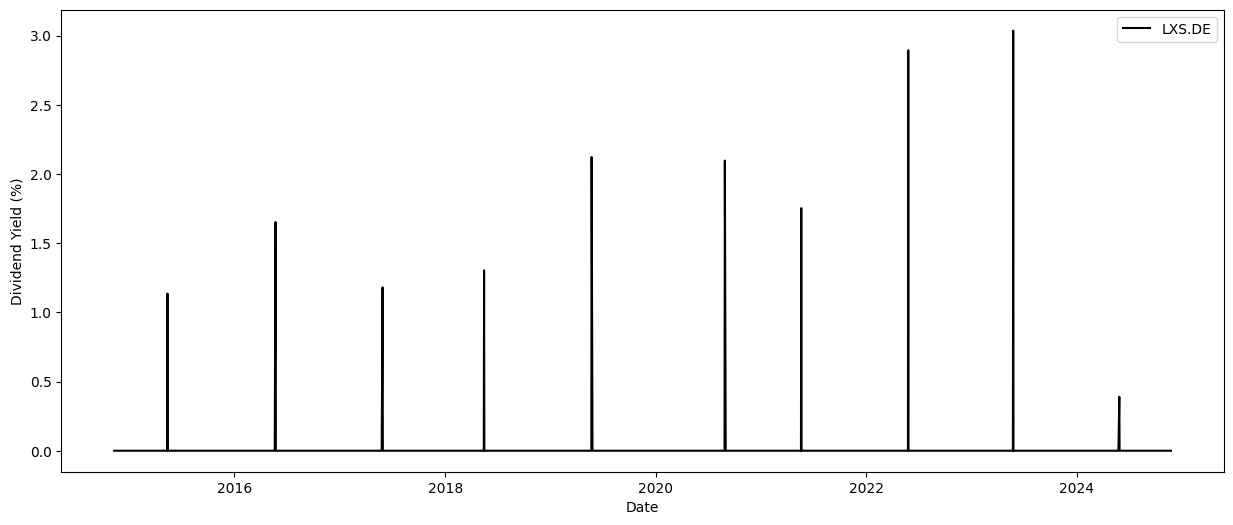

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.550205
share_price      1.000000
Name: share_price, dtype: float64


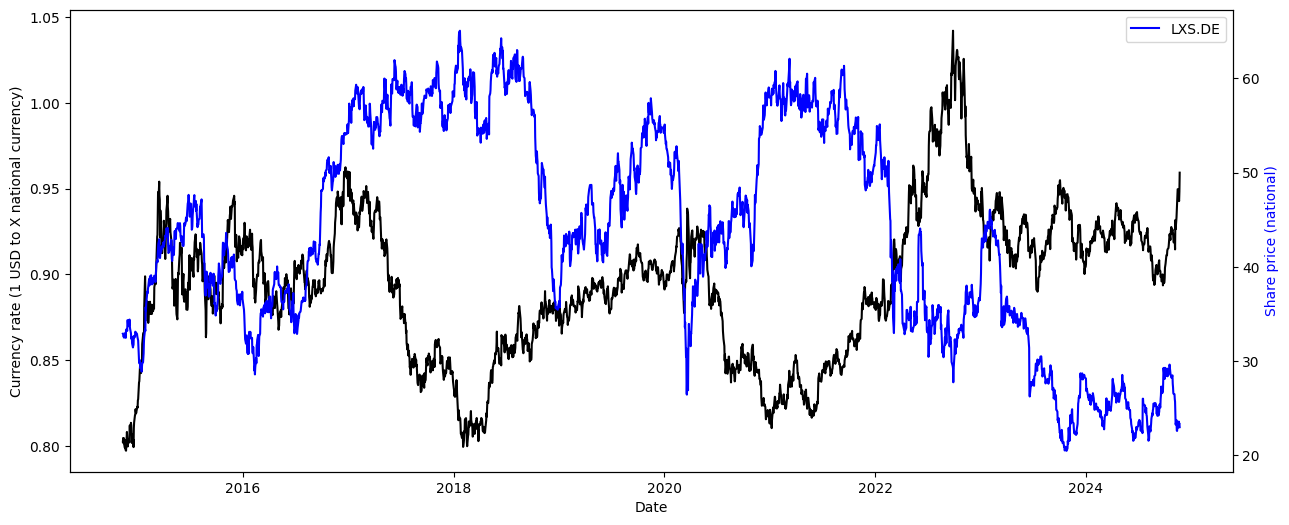

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

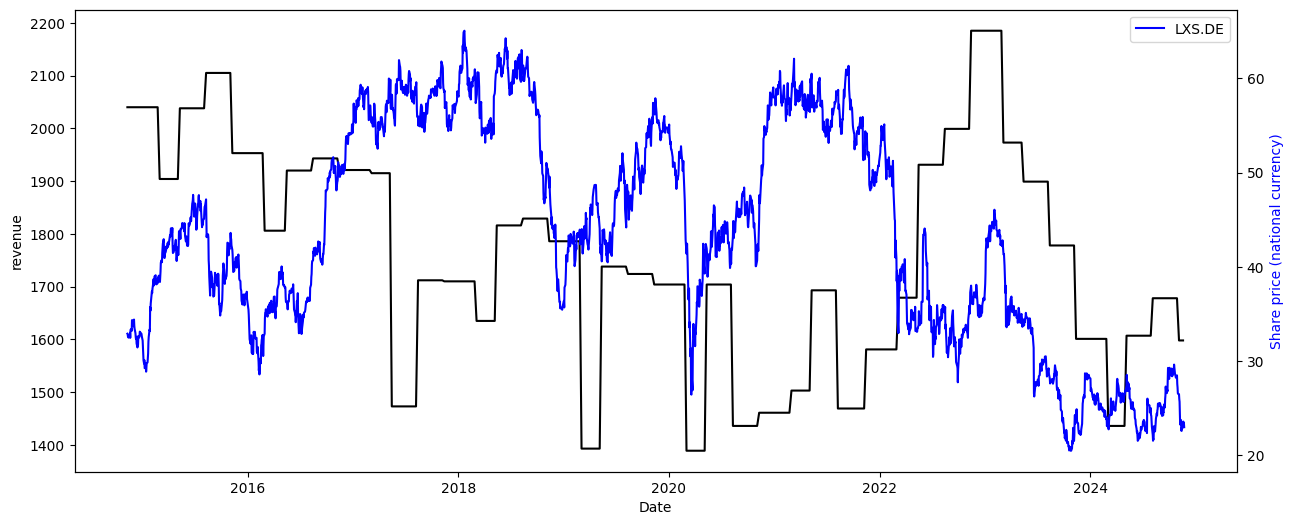

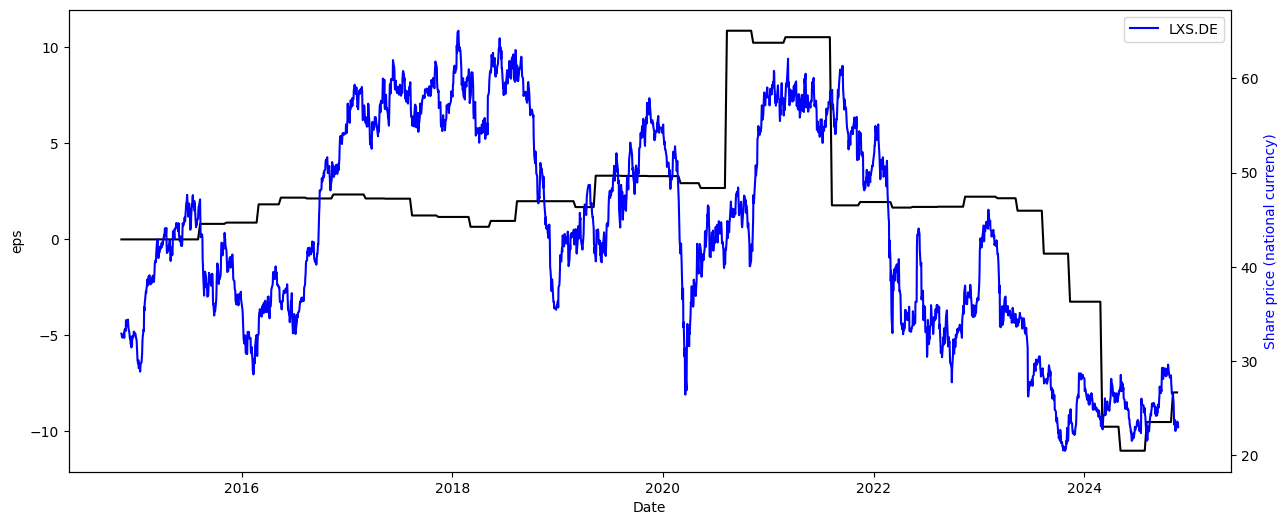

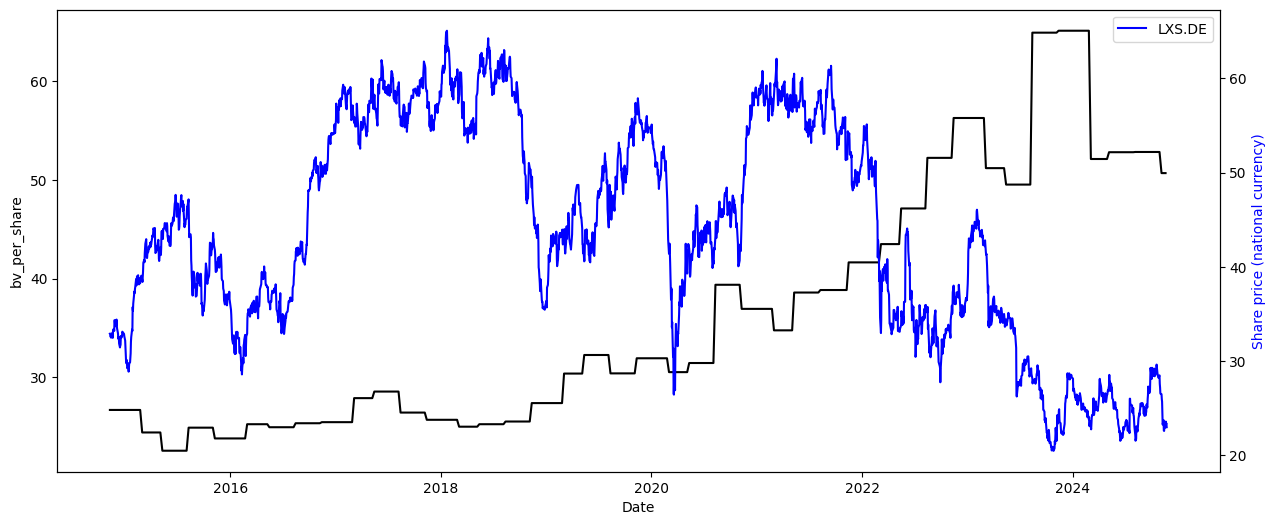

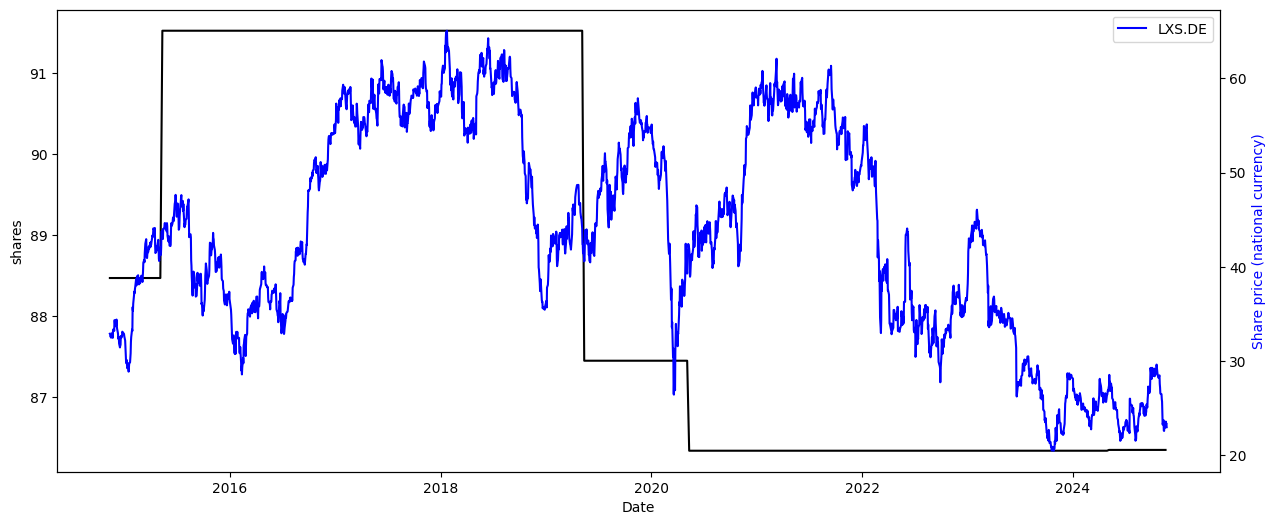

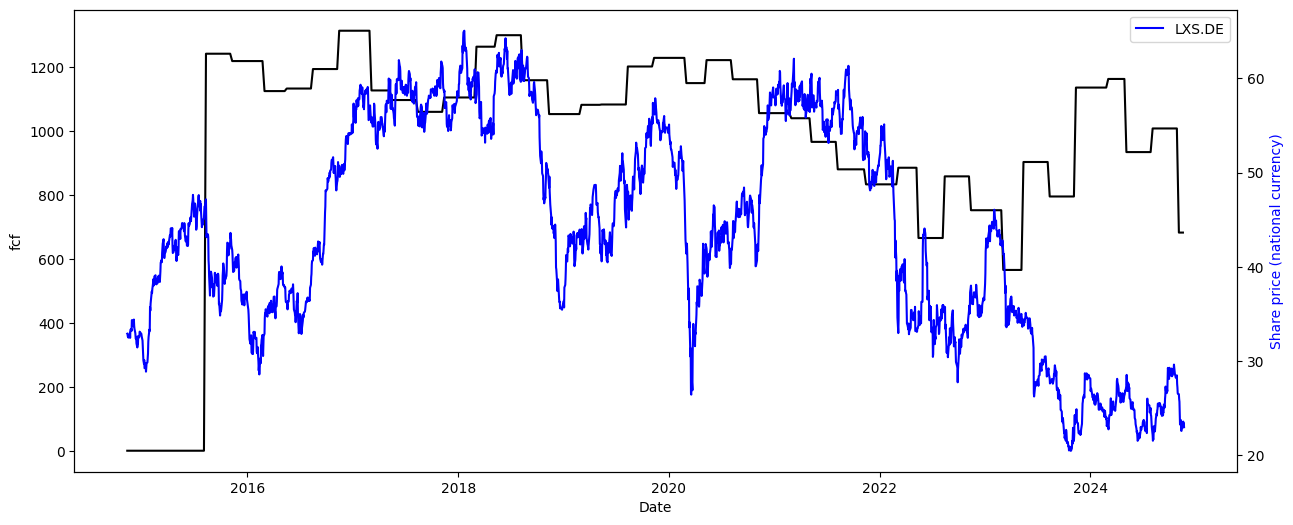

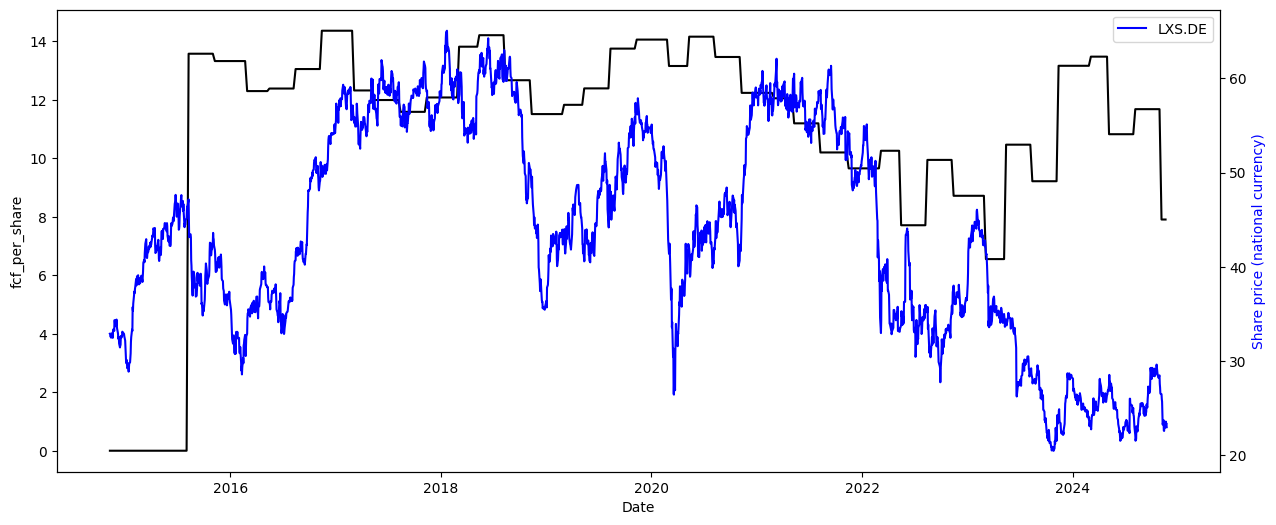

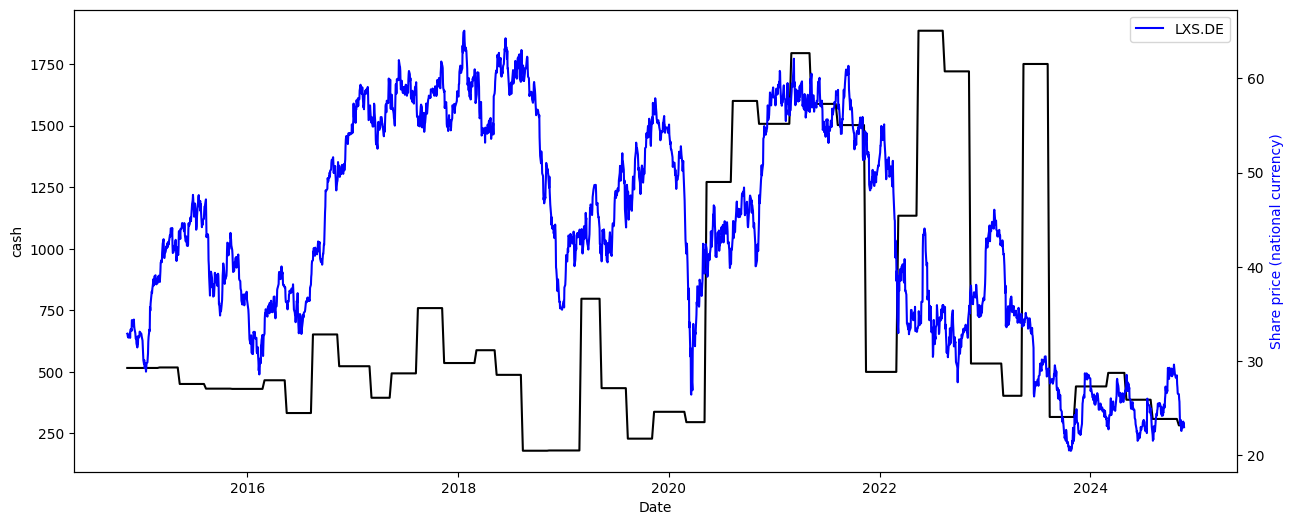

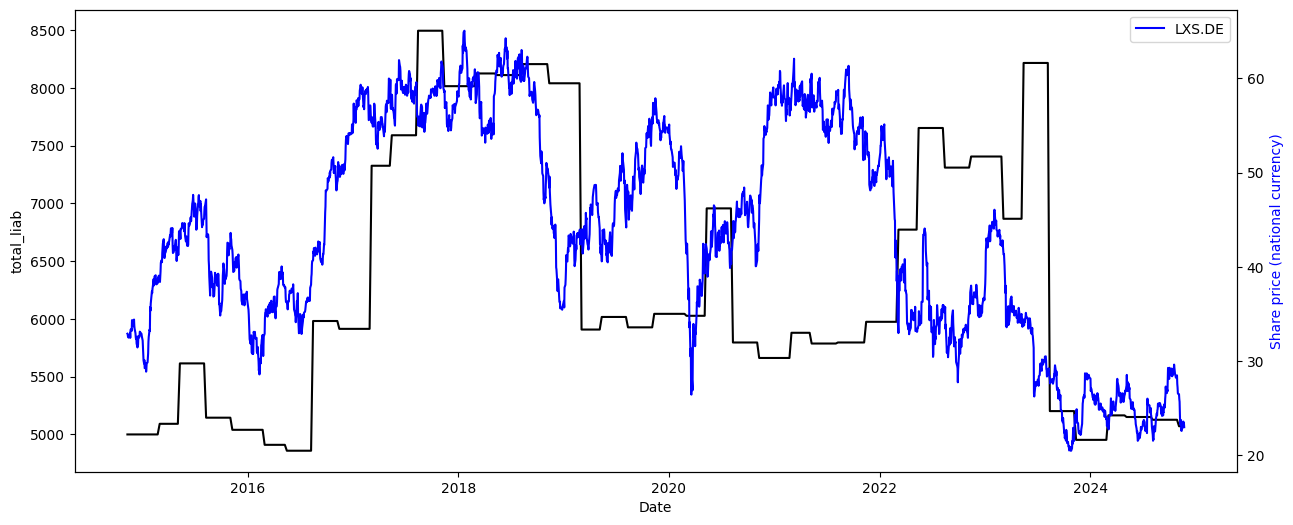

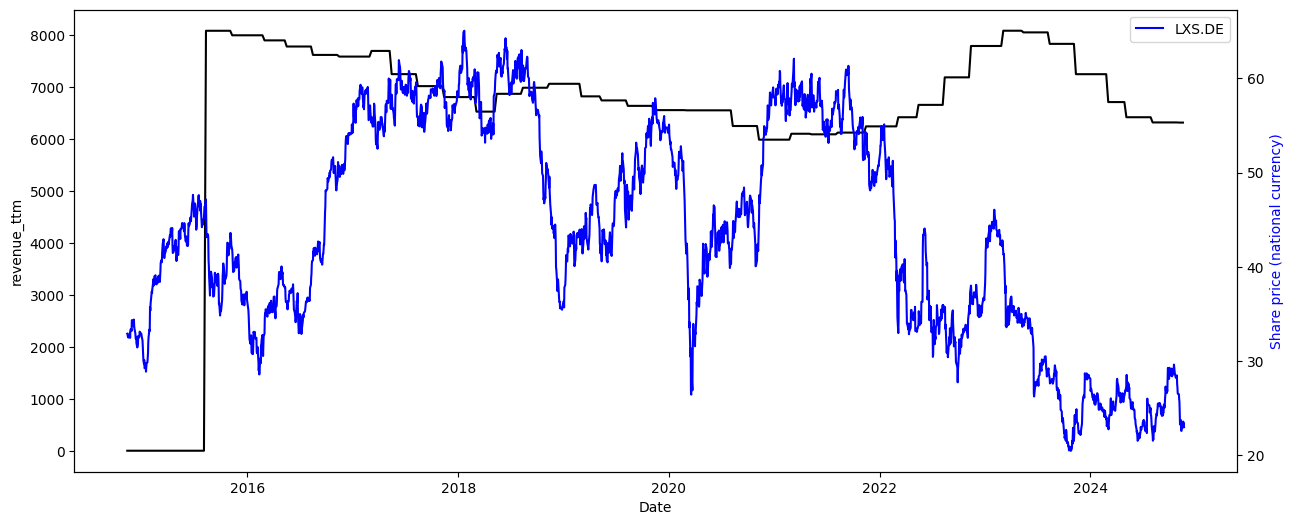

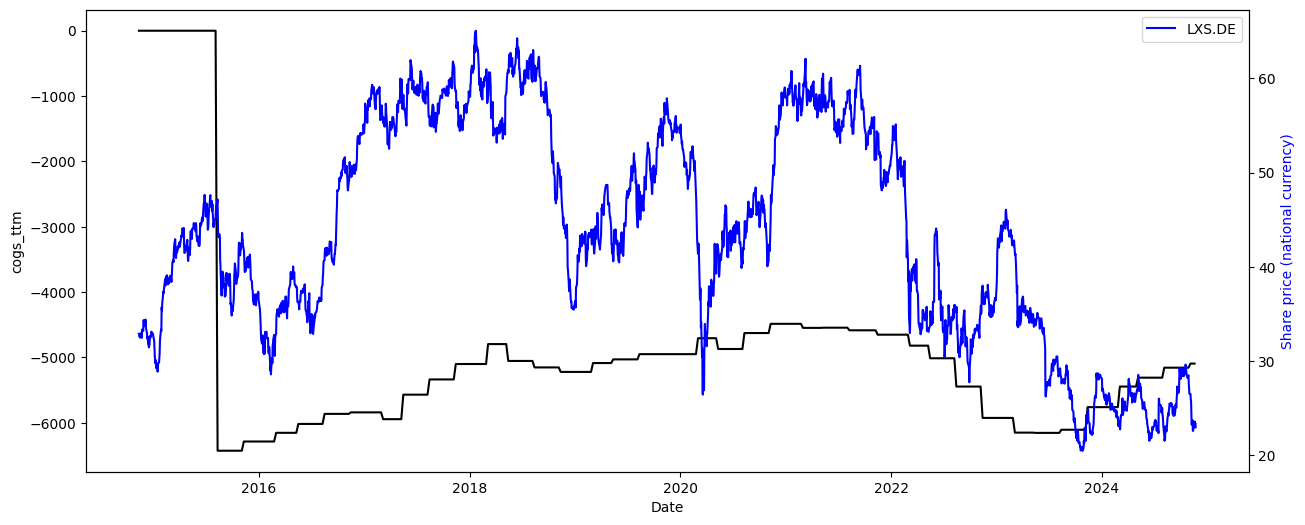

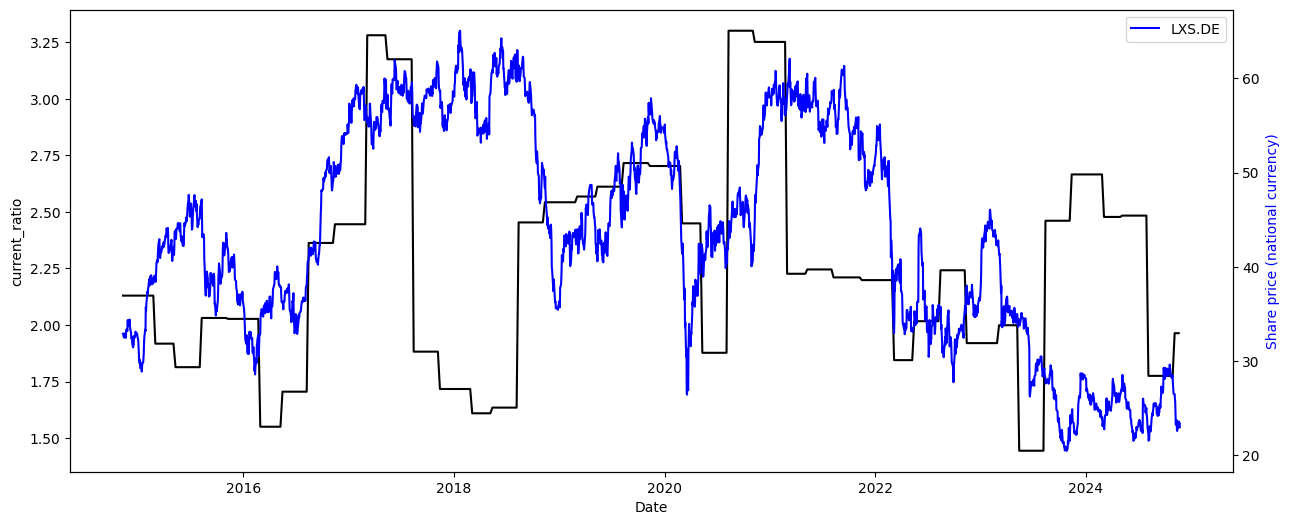

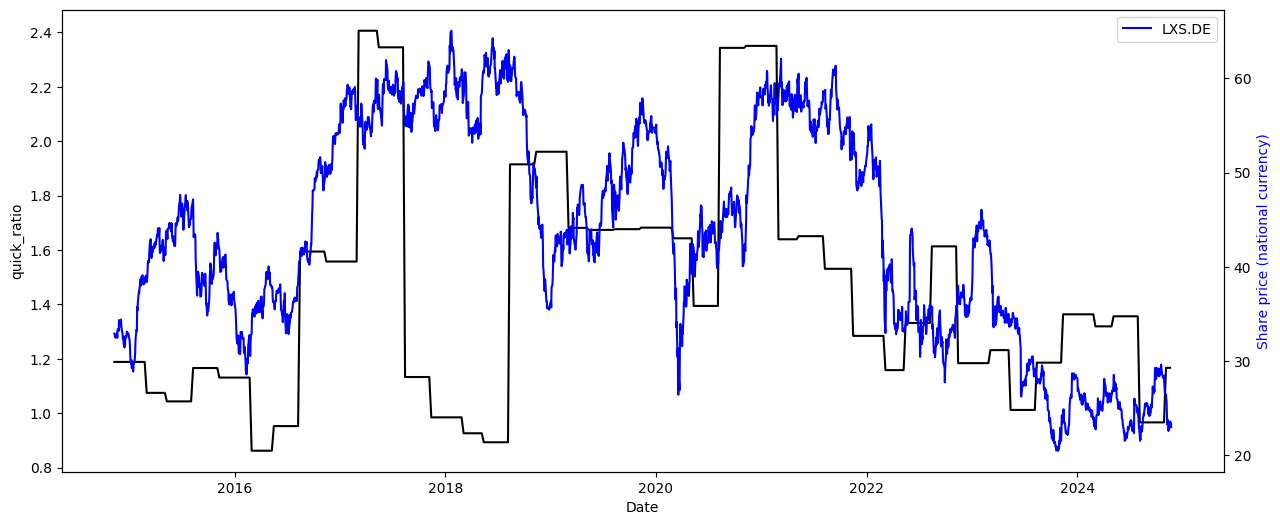

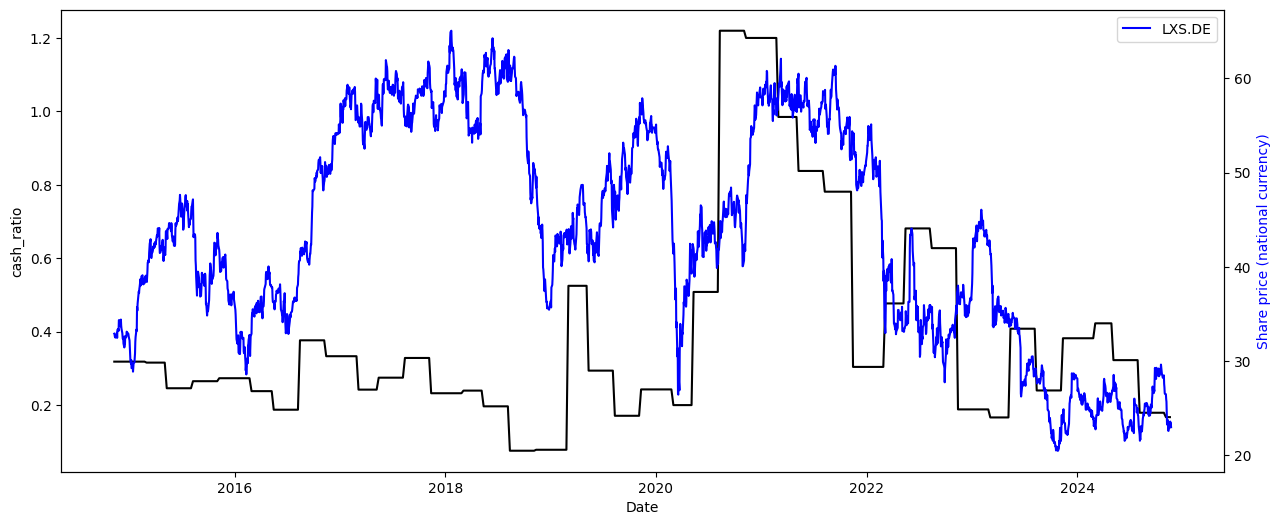

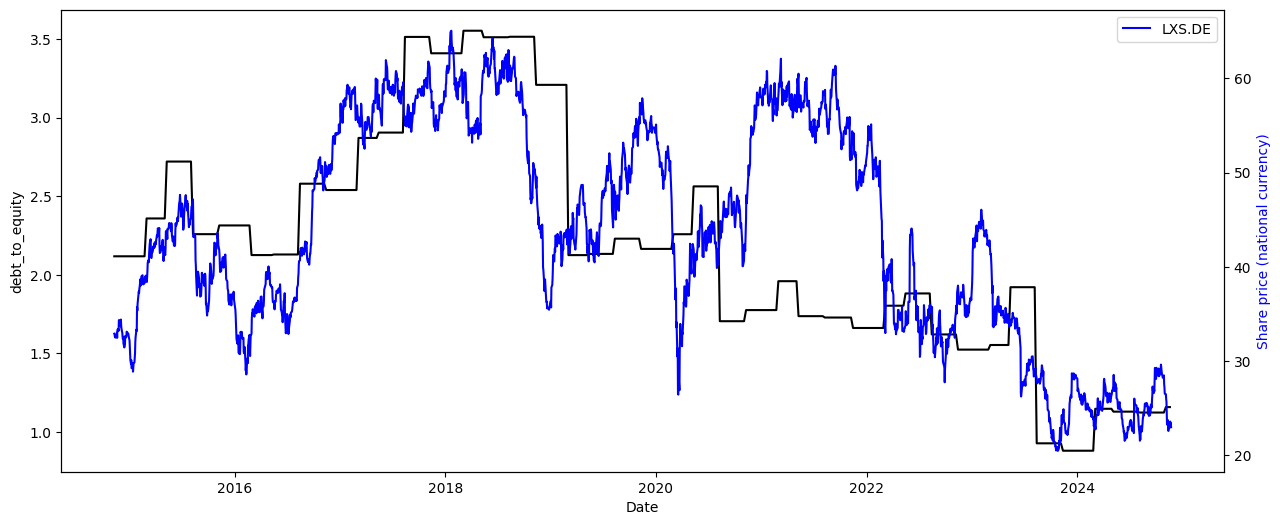

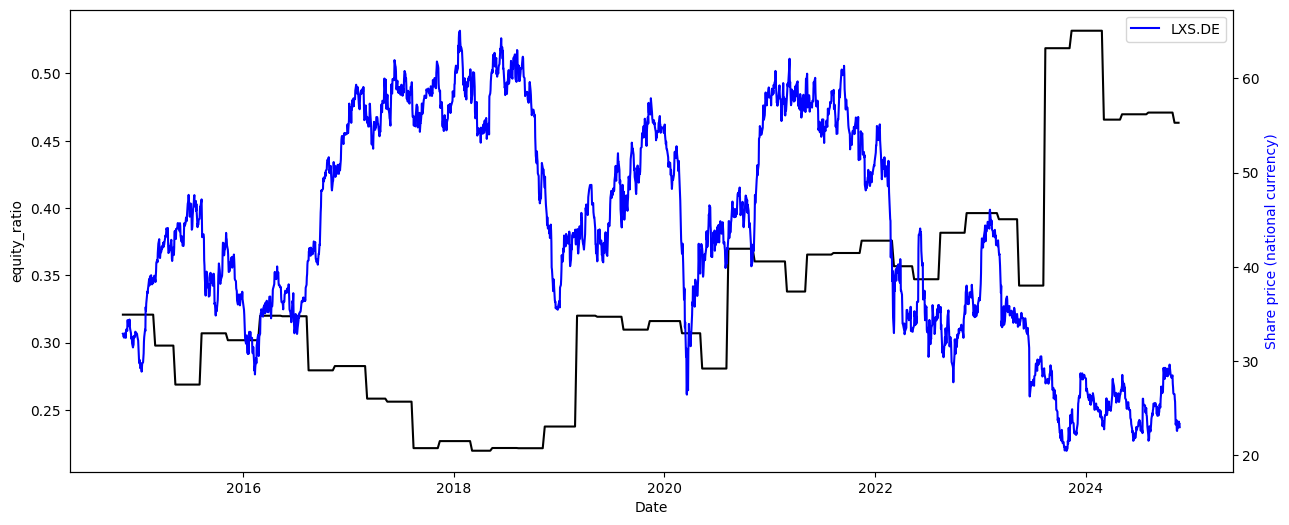

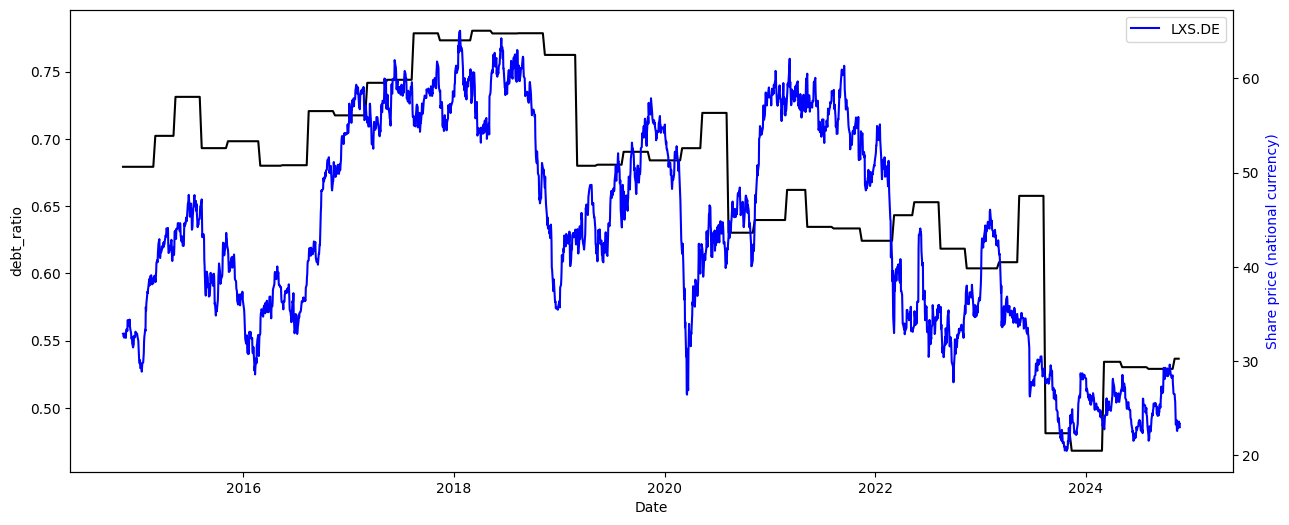

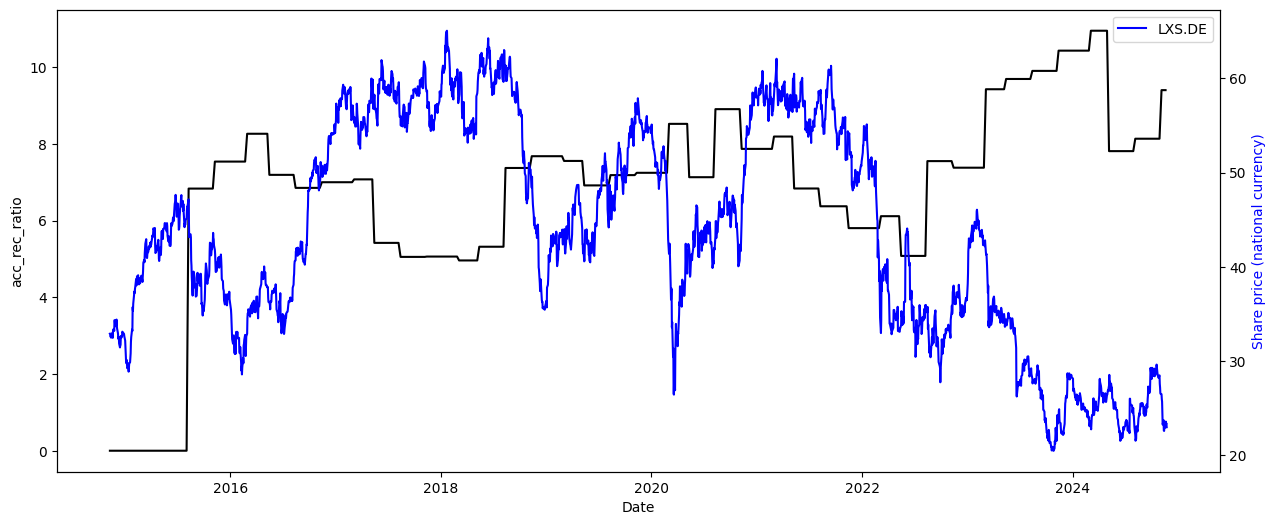

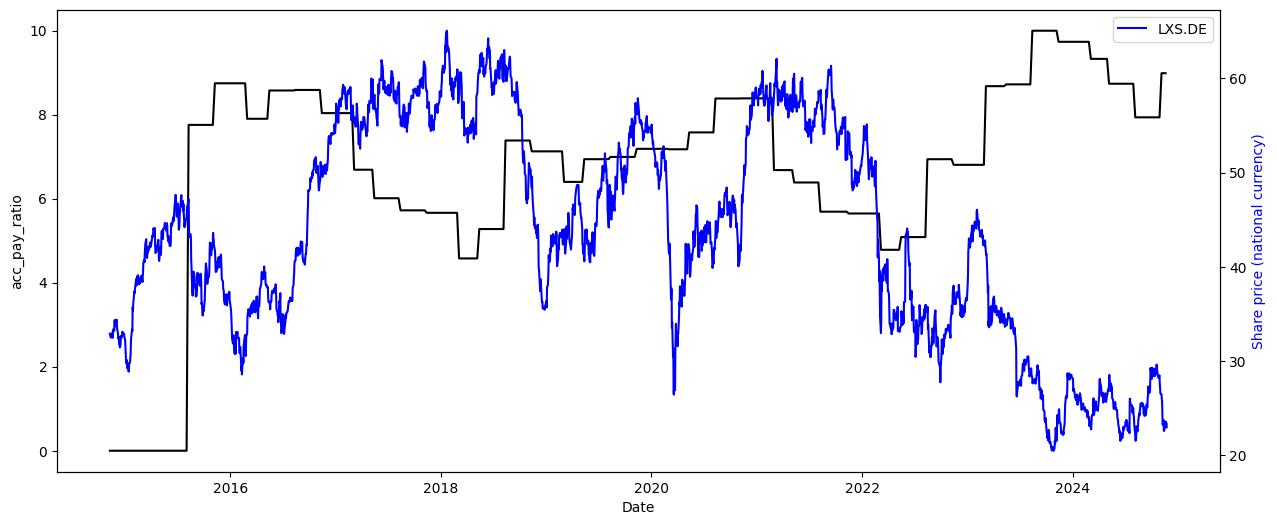

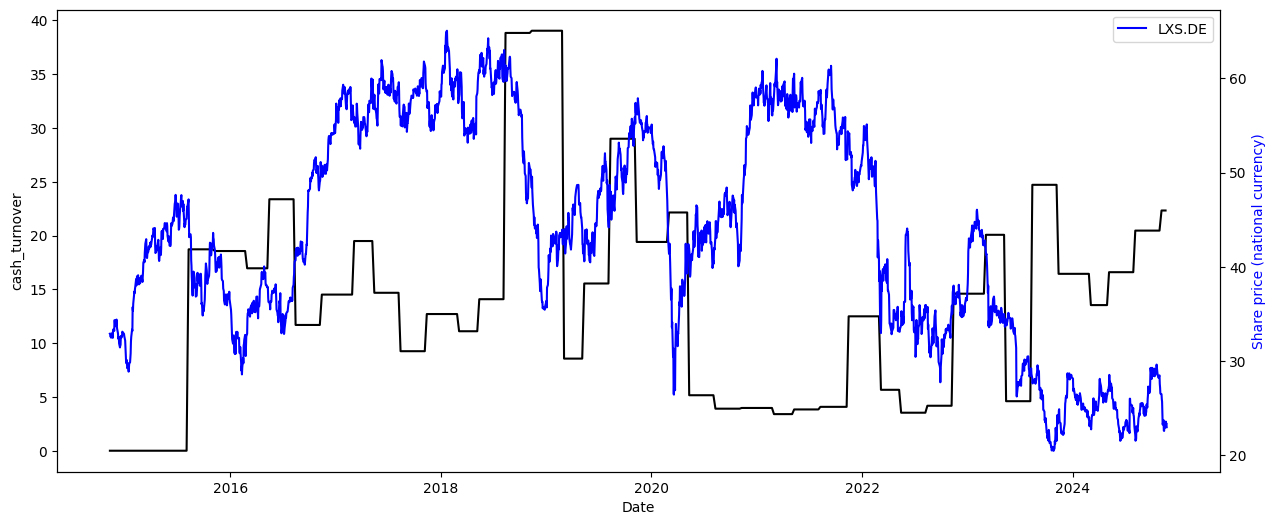

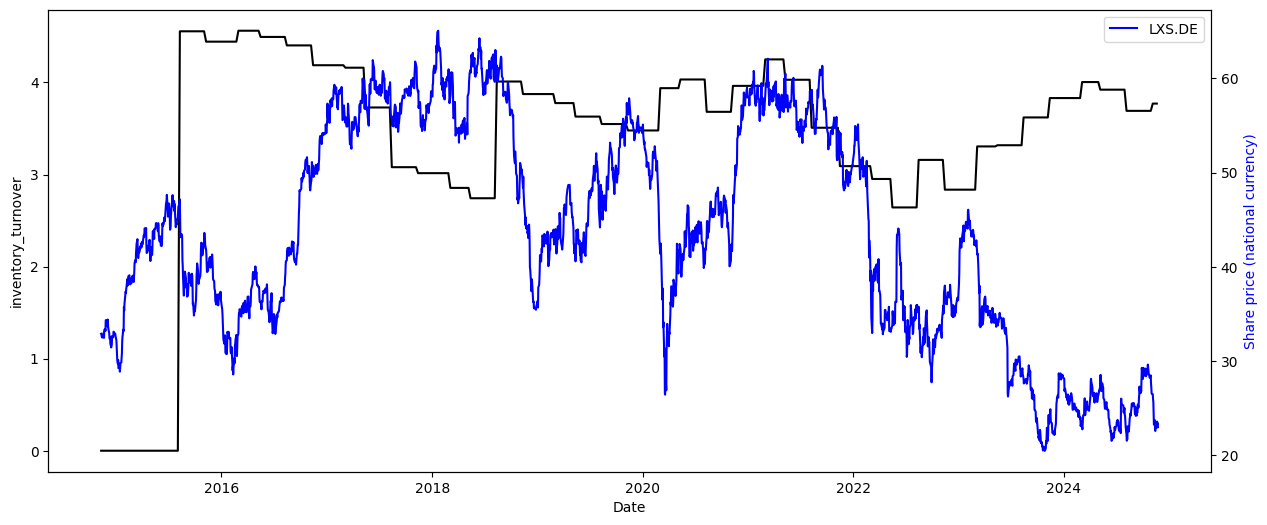

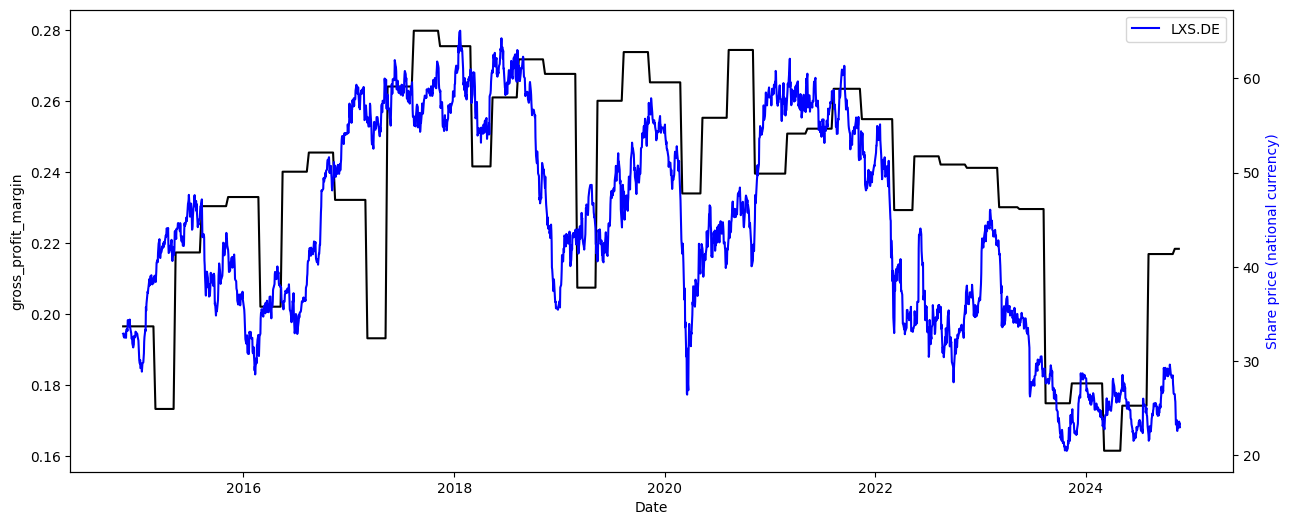

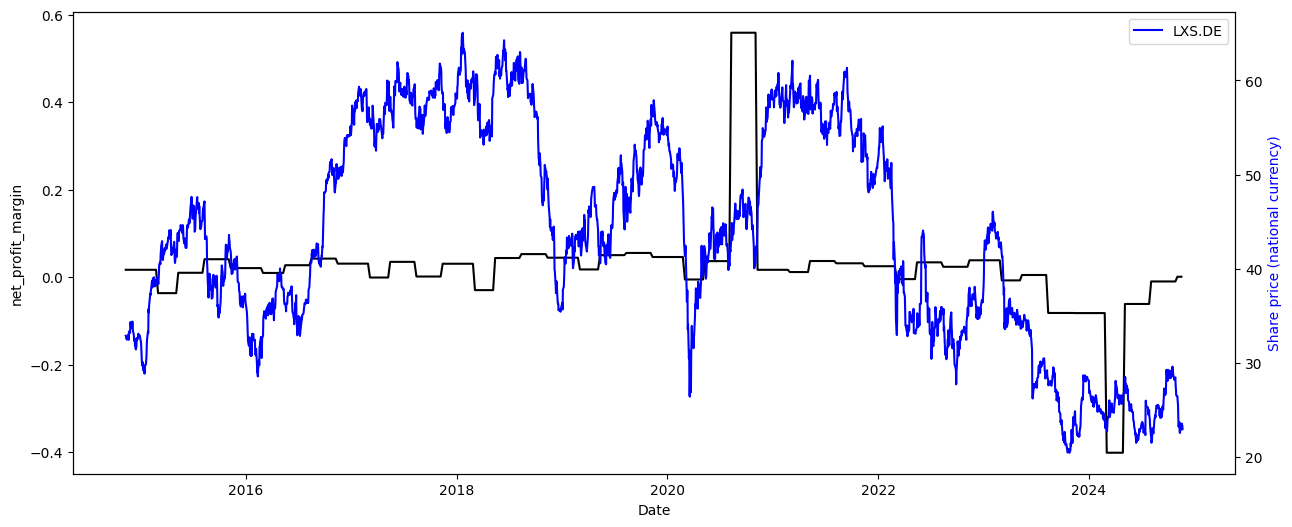

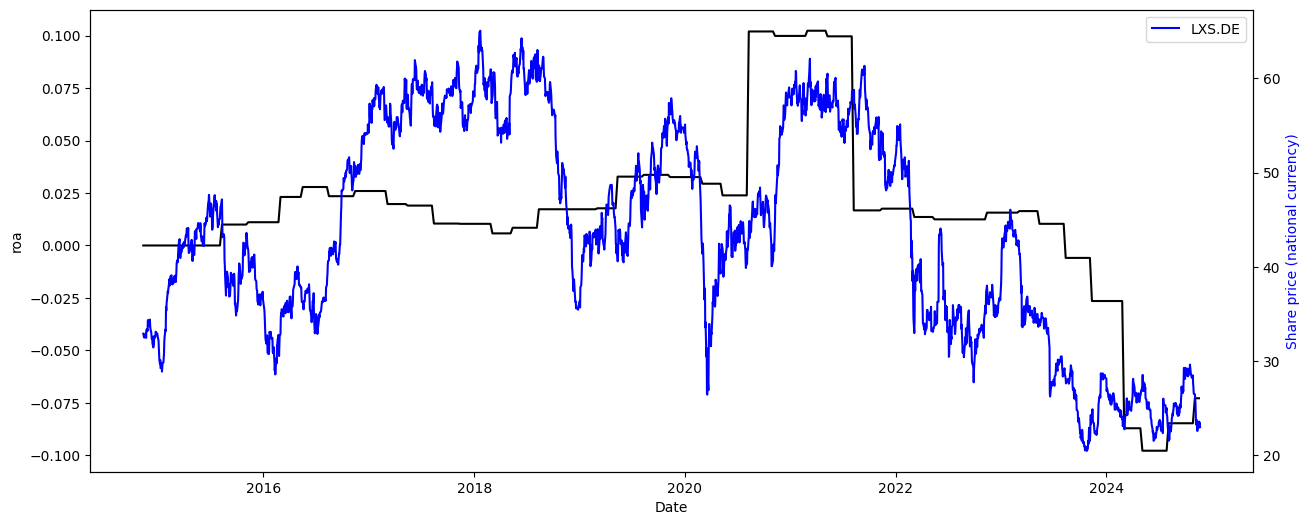

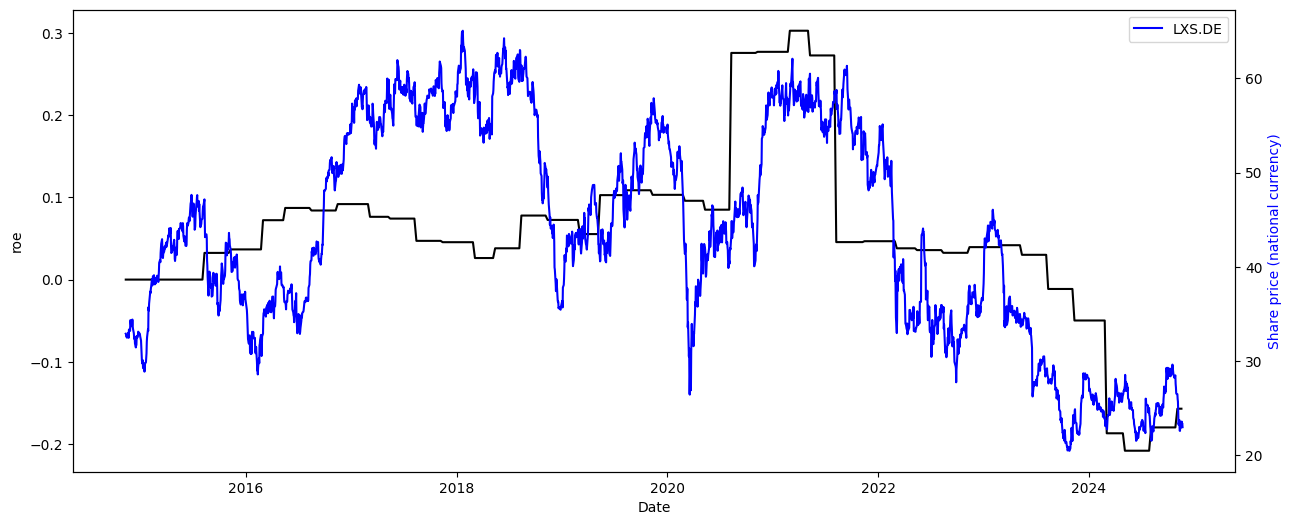

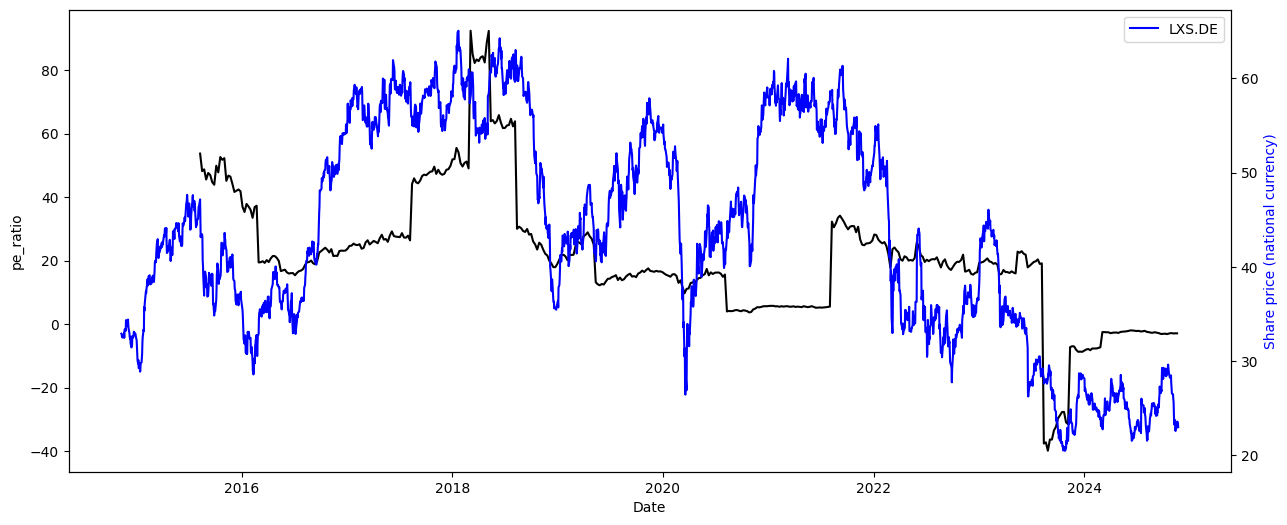

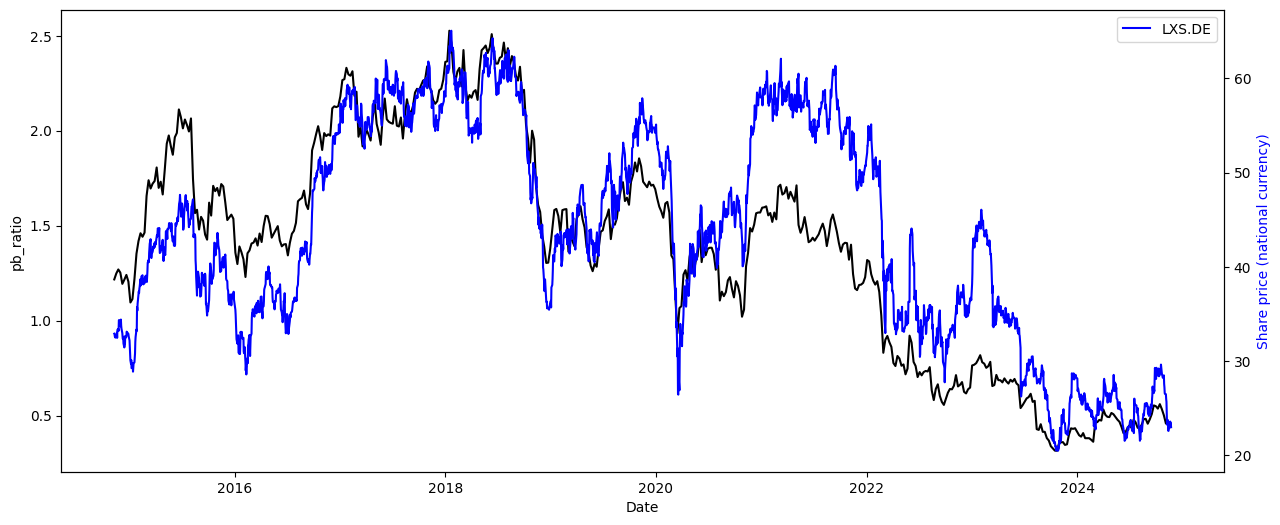

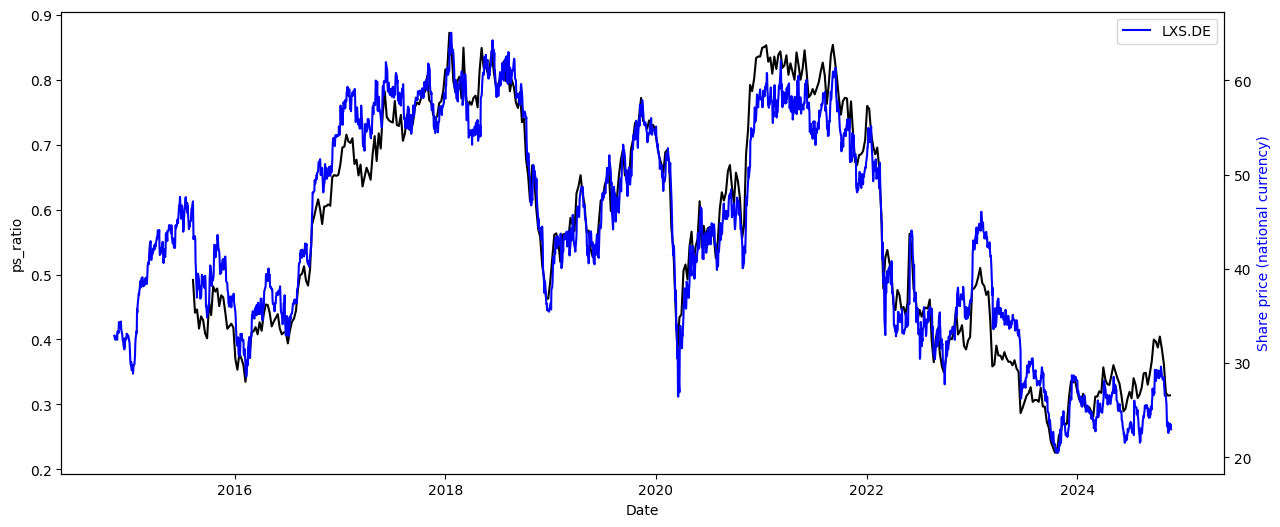

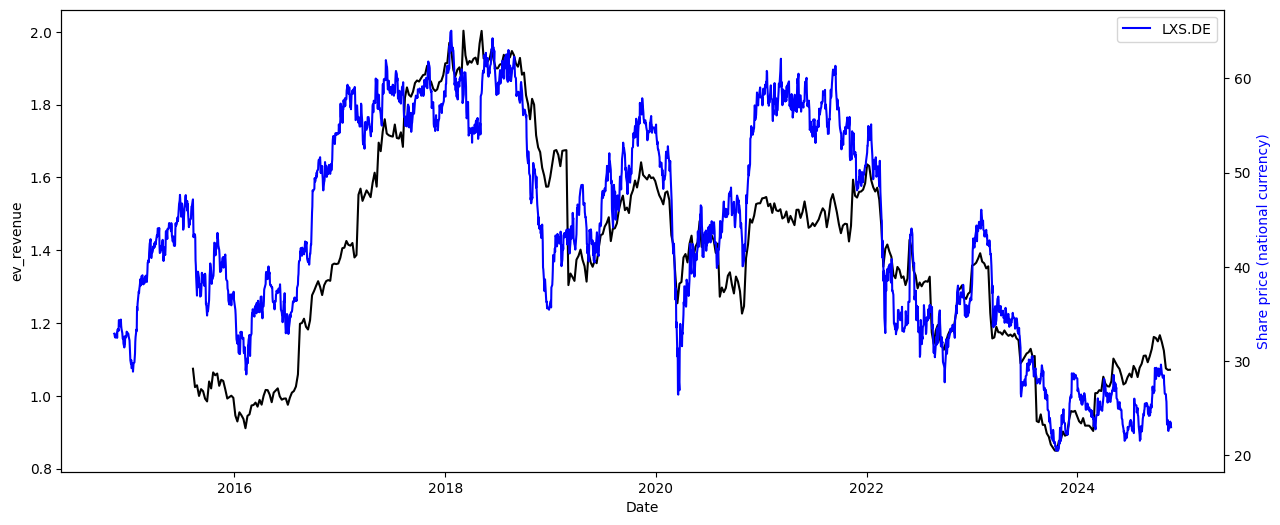

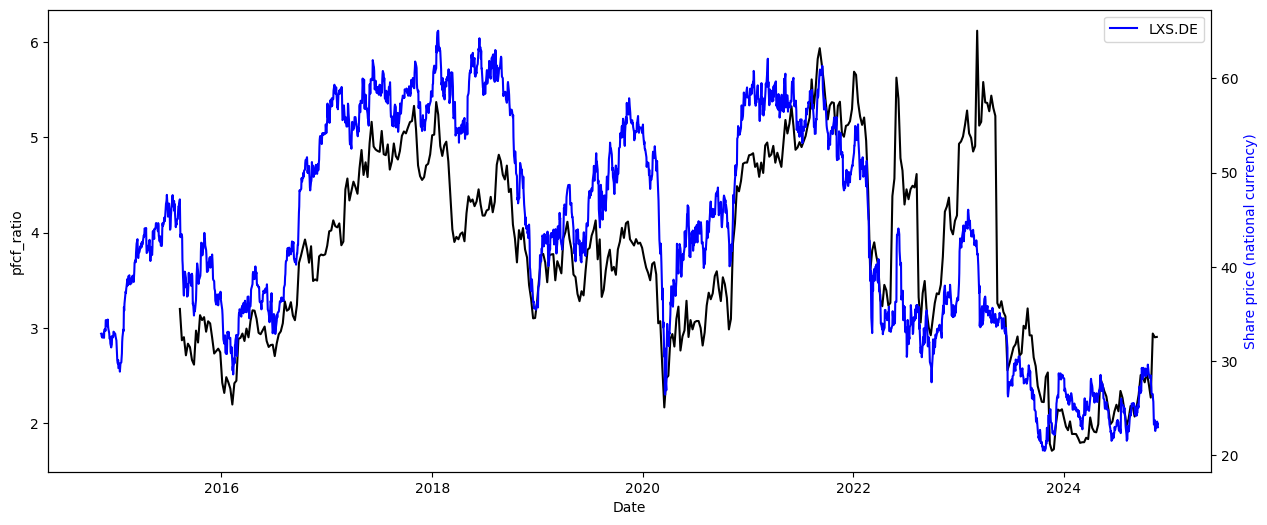

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

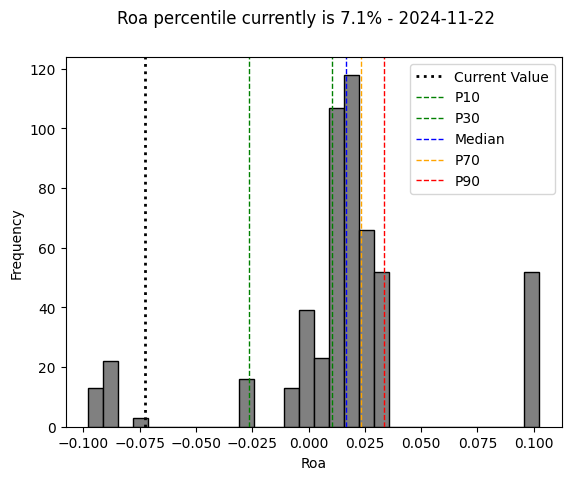

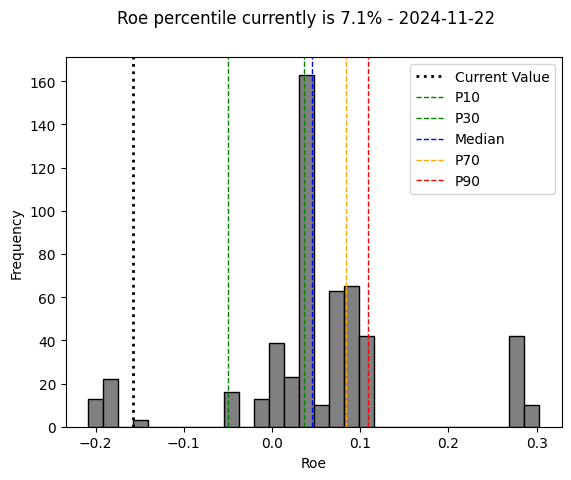

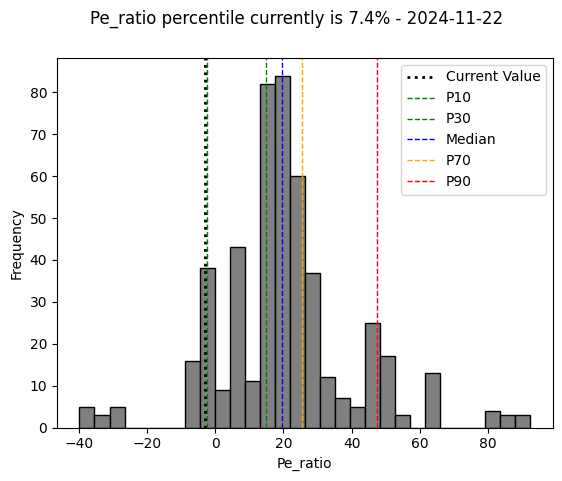

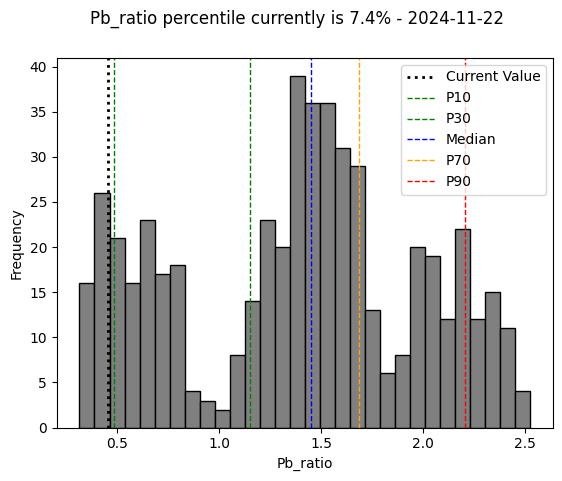

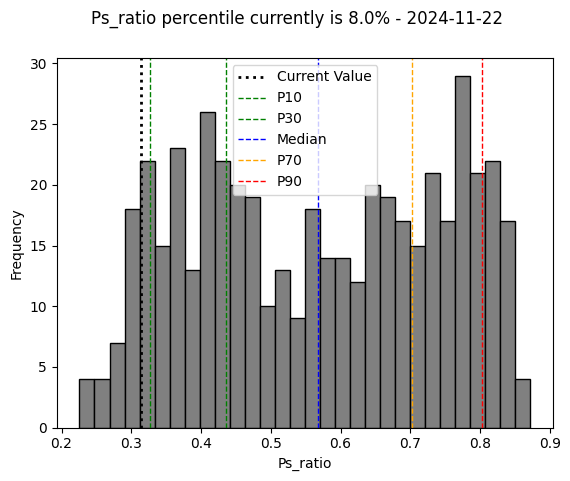

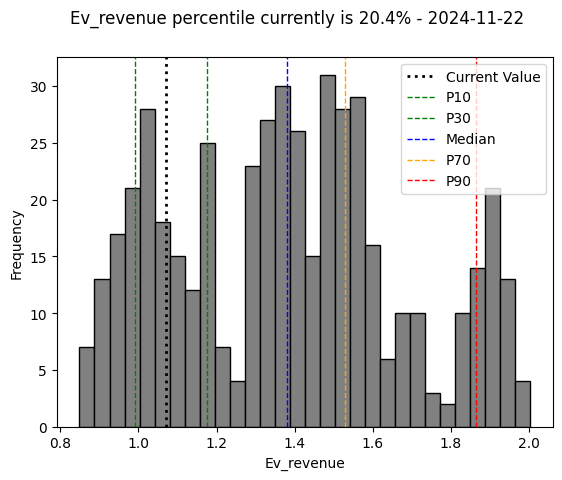

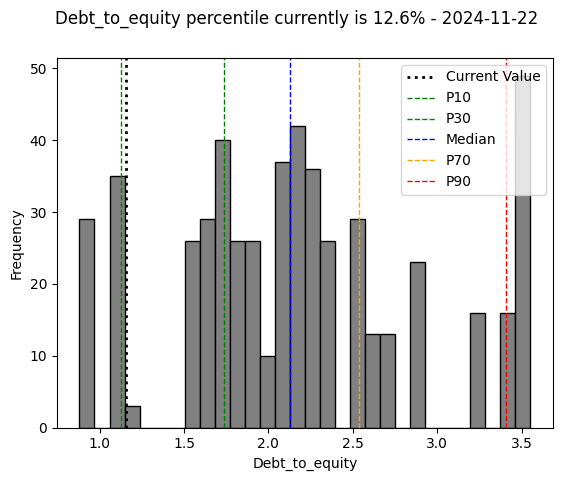

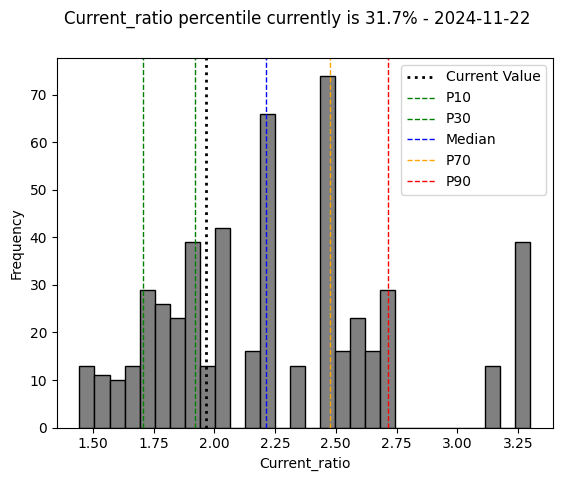

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.993401,0.084897,0.381555,0.576489,0.311498,0.215404,0.306189
roe,0.993401,1.000000,0.064698,0.405157,0.604436,0.336754,0.234595,0.349036
pe_ratio,0.084897,0.064698,1.000000,0.699843,0.486560,0.592214,0.769627,-0.402565
pb_ratio,0.381555,0.405157,0.699843,1.000000,0.810597,0.751972,0.875760,0.007092
ps_ratio,0.576489,0.604436,0.486560,0.810597,1.000000,0.859589,0.592908,0.205368
ev_revenue,0.311498,0.336754,0.592214,0.751972,0.859589,1.000000,0.764192,0.056926
debt_to_equity,0.215404,0.234595,0.769627,0.875760,0.592908,0.764192,1.000000,-0.154870
current_ratio,0.306189,0.349036,-0.402565,0.007092,0.205368,0.056926,-0.154870,1.000000


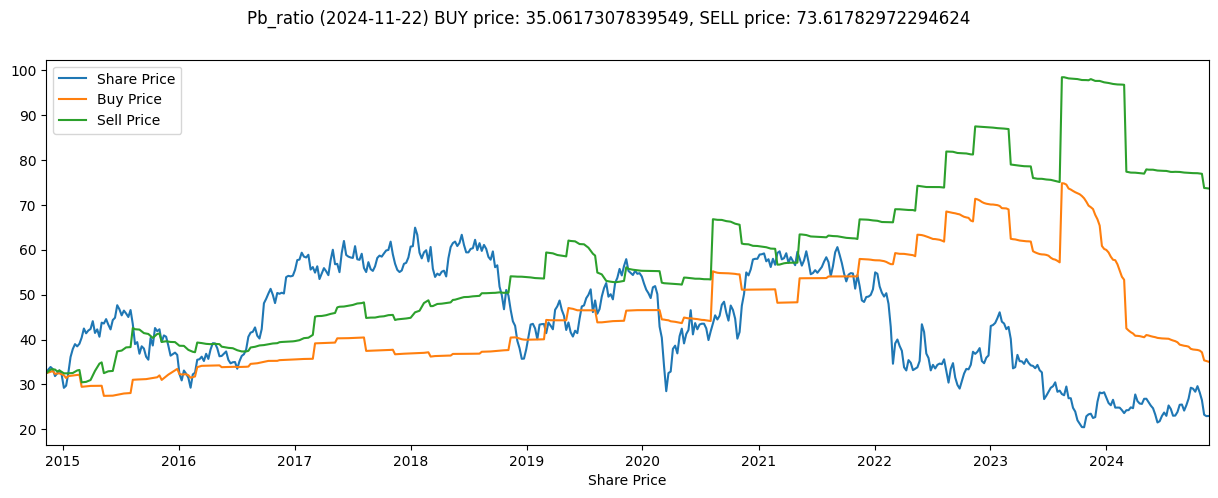

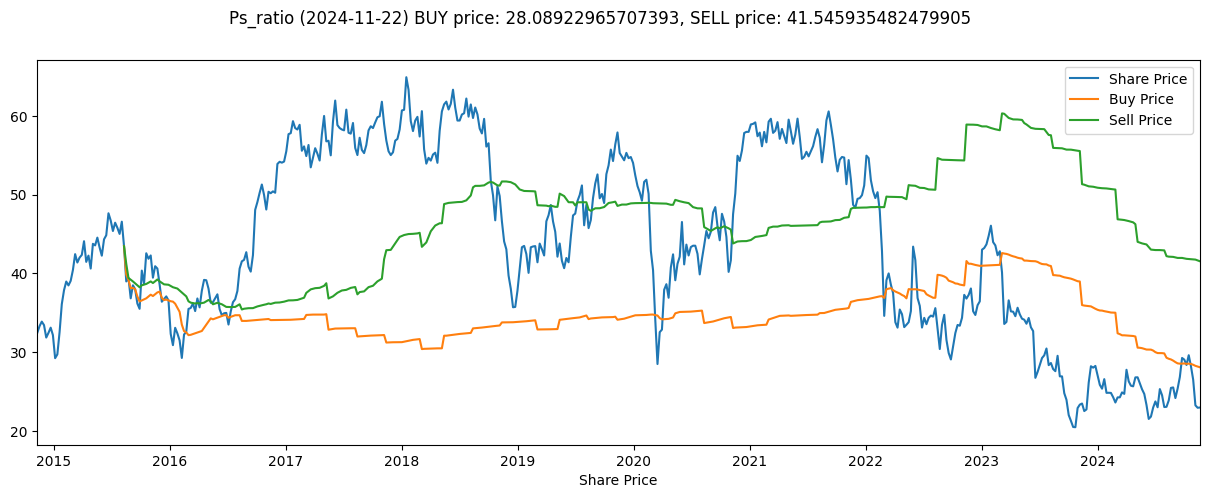

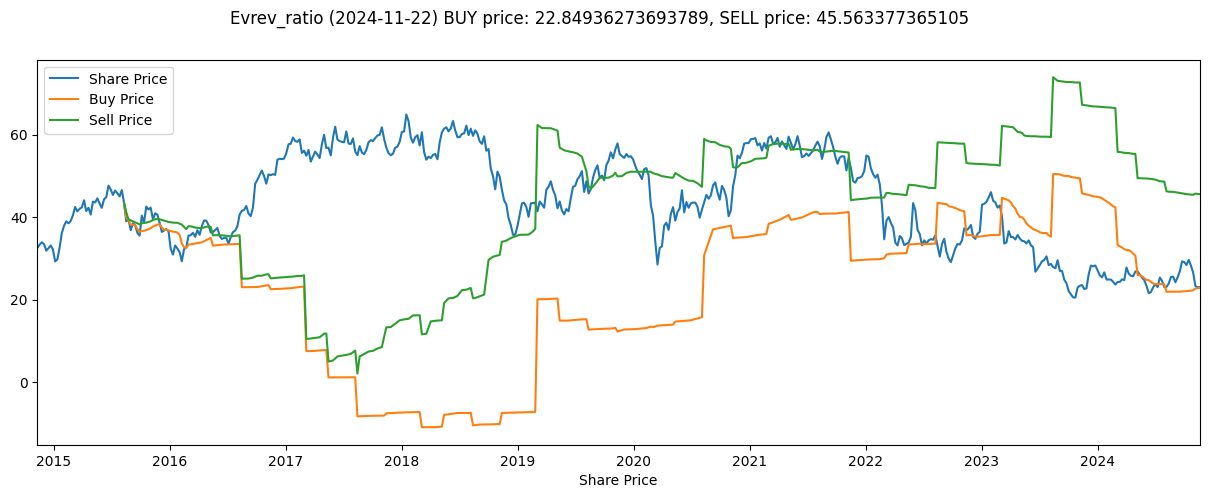

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)